# Reading ECCO $χ_{redi}$

In [251]:
%load_ext watermark

from pathlib import Path

import cf_xarray as cfxr
import dask
import ecco_v4_py as ecco
import matplotlib as mpl
import ncar_jobqueue
import numpy as np
import xgcm
from distributed import Client

import xarray as xr

%watermark -iv

xr.set_options(display_expand_data=False)

dirname = "/glade/work/dcherian/mitgcm/ECCOV4/release4/run/diags/"


def open_directory(dirname):
    import xmitgcm

    ds = xr.merge(
        [
            dask.optimize(
                xmitgcm.open_mdsdataset(
                    str(path),
                    dirname + "../",
                    geometry="llc",
                    chunks={"face": 1, "k_l": -1, "k": -1},
                    llc_method="smallchunks",
                ).chunk({"time": 50})
            )[0]
            for path in Path(dirname).glob("*")
        ],
        compat="override",
    )  # .sel(face=2)
    ds.coords["drC_kl"] = ds.drC.isel(k_p1=slice(-1)).rename({"k_p1": "k_l"}).variable

    grid = xgcm.Grid(
        ds,
        periodic=False,
        boundary="fill",
        fill_value=np.nan,
        metrics={
            ("X",): ["dxC", "dxG"],  # X distances
            ("Y",): ["dyC", "dyG"],  # Y distances
            ("Z",): ["drF", "drC", "drC_kl"],  # Z distances
            ("X", "Y"): ["rA", "rAz", "rAs", "rAw"],  # Areas
        },
    )
    dsfull["Tx"] = grid.derivative(dsfull.THETA, "X")
    dsfull["Ty"] = grid.derivative(dsfull.THETA, "Y")
    dsfull["Tz"] = -1 * grid.derivative(dsfull.THETA, "Z")

    dsfull["GM_CHI"] = (
        grid.interp(dsfull.GM_CHIX + dsfull.GM_CHIXO, "X", to="center")
        + grid.interp(dsfull.GM_CHIY + dsfull.GM_CHIYO, "Y", to="center")
        + grid.interp(dsfull.GM_CHIZ, "Z", to="center")
    )
    return ds, grid

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
numpy        : 1.23.5
sys          : 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:08:06) [GCC 11.3.0]
xgcm         : 0.6.1
pandas       : 1.5.3
dask         : 2023.3.2
ecco_v4_py   : 1.5.5
matplotlib   : 3.7.1
json         : 2.0.9
xarray       : 2023.3.0
ncar_jobqueue: 2021.4.14
cf_xarray    : 0.8.0



In [2]:
cluster = ncar_jobqueue.NCARCluster(
    local_directory="/local_scratch/pbs.$PBS_JOBID/dask/spill"
)
cluster
cluster.adapt(minimum_jobs=1, maximum_jobs=6)

/glade/u/home/dcherian/miniconda3/envs/eddydiff/lib/python3.10/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/u/home/dcherian/miniconda3/envs/eddydiff/lib/python3.10/site-packages/dask_jobqueue/core.py:274: FutureWarning: env_extra has been renamed to job_script_prologue. You are still using it (even if only set to []; please also check config files). If you did not set job_script_prologue yet, env_extra will be respected for now, but it will be removed in a future release. If you already set job_script_prologue, env_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/gl

In [3]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/dcherian/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/dcherian/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.37:33905,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/dcherian/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
%ls /glade/work/dcherian/mitgcm/ECCOV4/release4/run/diags/

GM_CHIX/   GM_CHIY/   GM_CHIZ/  GM_Kuz/  GM_Kvz/  GM_Kwy/  GM_KwzTz/  THETA/
GM_CHIXO/  GM_CHIYO/  GM_Kux/   GM_Kvy/  GM_Kwx/  GM_Kwz/  GM_ubT/


In [5]:
cluster.scale(2)

In [243]:
dsfull, grid = open_directory("/glade/work/dcherian/mitgcm/ECCOV4/release4/run/diags/")
dsfull

/glade/u/home/dcherian/miniconda3/envs/eddydiff/lib/python3.10/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/u/home/dcherian/miniconda3/envs/eddydiff/lib/python3.10/site-packages/dask_jobqueue/core.py:274: FutureWarning: env_extra has been renamed to job_script_prologue. You are still using it (even if only set to []; please also check config files). If you did not set job_script_prologue yet, env_extra will be respected for now, but it will be removed in a future release. If you already set job_script_prologue, env_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/gl

<xarray.Dataset>
Dimensions:    (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_u: 50, k_l: 50,
                k_p1: 51, face: 13, time: 24)
Coordinates: (12/45)
  * i          (i) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j          (j) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k          (k) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * k_u        (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
    ...         ...
    maskCtrlC  (k, face, j, i) bool dask.array<chunksize=(50, 1, 90, 90), meta=np.ndarray>
    maskCtrlS  (k, face, j_g, i) bool dask.array<chunksize=(50, 1, 90, 90), meta=np.ndarray>
    rhoRef     (k) >f4 dask.array<chunksize=(50,), meta=np.ndarray>
    maskCtrlW  (k, face, j, i_g) bool dask.array<chunksize=(50, 1, 90, 90), meta=np.ndarray>
    iter       (time) float64 dask.array<chunksize=(24,), meta=np.ndarray>
    drC_kl     (k_l) >f4 dask.array<chunksize=(50,), meta=np.ndarray>
Data variables: (12/15)
    GM_CHIXO   (time, k, face, j, i_g) float32 dask.array<chunksize=(24, 50, 1, 90, 90), meta=np.ndarray>
    GM_CHIZ    (time, k_l, face, j, i) float32 dask.array<chunksize=(24, 50, 1, 90, 90), meta=np.ndarray>
    GM_ubT     (time, k, face, j, i_g) float32 dask.array<chunksize=(24, 50, 1, 90, 90), meta=np.ndarray>
    GM_CHIX    (time, k, face, j, i_g) float32 dask.array<chunksize=(24, 50, 1, 90, 90), meta=np.ndarray>
    GM_CHIYO   (time, k, face, j_g, i) float32 dask.array<chunksize=(24, 50, 1, 90, 90), meta=np.ndarray>
    GM_Kvz     (time, k, face, j_g, i) float32 dask.array<chunksize=(24, 50, 1, 90, 90), meta=np.ndarray>
    ...         ...
    GM_Kwy     (time, k_l, face, j, i) float32 dask.array<chunksize=(24, 50, 1, 90, 90), meta=np.ndarray>
    GM_KwzTz   (time, k_l, face, j, i) float32 dask.array<chunksize=(24, 50, 1, 90, 90), meta=np.ndarray>
    GM_Kux     (time, k, face, j, i_g) float32 dask.array<chunksize=(24, 50, 1, 90, 90), meta=np.ndarray>
    GM_Kwx     (time, k_l, face, j, i) float32 dask.array<chunksize=(24, 50, 1, 90, 90), meta=np.ndarray>
    GM_CHIY    (time, k, face, j_g, i) float32 dask.array<chunksize=(24, 50, 1, 90, 90), meta=np.ndarray>
    GM_Kuz     (time, k, face, j, i_g) float32 dask.array<chunksize=(24, 50, 1, 90, 90), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir='/glade/work/d...

In [252]:
ds = dsfull.sel(face=2).load()

/glade/u/home/dcherian/miniconda3/envs/eddydiff/lib/python3.10/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/u/home/dcherian/miniconda3/envs/eddydiff/lib/python3.10/site-packages/dask_jobqueue/core.py:274: FutureWarning: env_extra has been renamed to job_script_prologue. You are still using it (even if only set to []; please also check config files). If you did not set job_script_prologue yet, env_extra will be respected for now, but it will be removed in a future release. If you already set job_script_prologue, env_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)


## NATRE region

In [ ]:
natre = ds.isel(i=slice(10, 18), j=slice(10, 20), i_g=slice(10, 18), j_g=slice(10, 20))

In [ ]:
natre.load(scheduler=client)

<xarray.Dataset>
Dimensions:    (i: 8, i_g: 8, j: 10, j_g: 10, k: 50, k_u: 50, k_l: 50,
                k_p1: 51, time: 24)
Coordinates: (12/45)
  * i          (i) int64 10 11 12 13 14 15 16 17
  * i_g        (i_g) int64 10 11 12 13 14 15 16 17
  * j          (j) int64 10 11 12 13 14 15 16 17 18 19
  * j_g        (j_g) int64 10 11 12 13 14 15 16 17 18 19
  * k          (k) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * k_u        (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
    ...         ...
    maskCtrlS  (k, j_g, i) bool True True True True ... False False False False
    rhoRef     (k) >f4 1.024e+03 1.024e+03 1.024e+03 ... 1.052e+03 1.054e+03
    maskCtrlW  (k, j, i_g) bool True True True True ... False False False False
    iter       (time) int64 1 2 3 4 5 6 7 8 9 10 ... 16 17 18 19 20 21 22 23 24
  * time       (time) timedelta64[ns] 00:00:01 00:00:02 ... 00:00:23 00:00:24
    drC_kl     (k_l) >f4 10.0 10.0 10.0 10.0 10.0 ... 399.0 422.0 445.0 228.2
Data variables: (12/19)
    GM_CHIZ    (time, k_l, j, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    GM_ubT     (time, k, j, i_g) float32 1.363e+06 1.334e+06 ... 0.0 0.0
    GM_CHIX    (time, k, j, i_g) float32 1.571e-09 3.038e-09 ... 0.0 0.0
    GM_Kvz     (time, k, j_g, i) float32 3.523 3.411 3.31 3.206 ... 0.0 0.0 0.0
    GM_Kwz     (time, k_l, j, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    THETA      (time, k, j, i) float32 23.1 22.98 22.81 22.6 ... 0.0 0.0 0.0 0.0
    ...         ...
    Tx         (time, k, j, i_g) float32 -8.891e-07 -1.213e-06 ... 0.0 0.0
    Ty         (time, k, j_g, i) float32 -2.024e-06 -1.976e-06 ... 0.0 0.0
    Tz         (time, k_l, j, i) float32 nan nan nan nan nan ... 0.0 0.0 0.0 0.0
    chix_      (time, k, j, i_g) float32 1.433e-09 2.585e-09 ... 0.0 0.0
    chiy_      (time, k, j_g, i) float32 7.264e-09 6.708e-09 ... 0.0 0.0
    GM_CHI     (time, k, j, i) float32 1.467e-08 2.126e-08 2.9e-08 ... nan nan
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir='/glade/work/d...

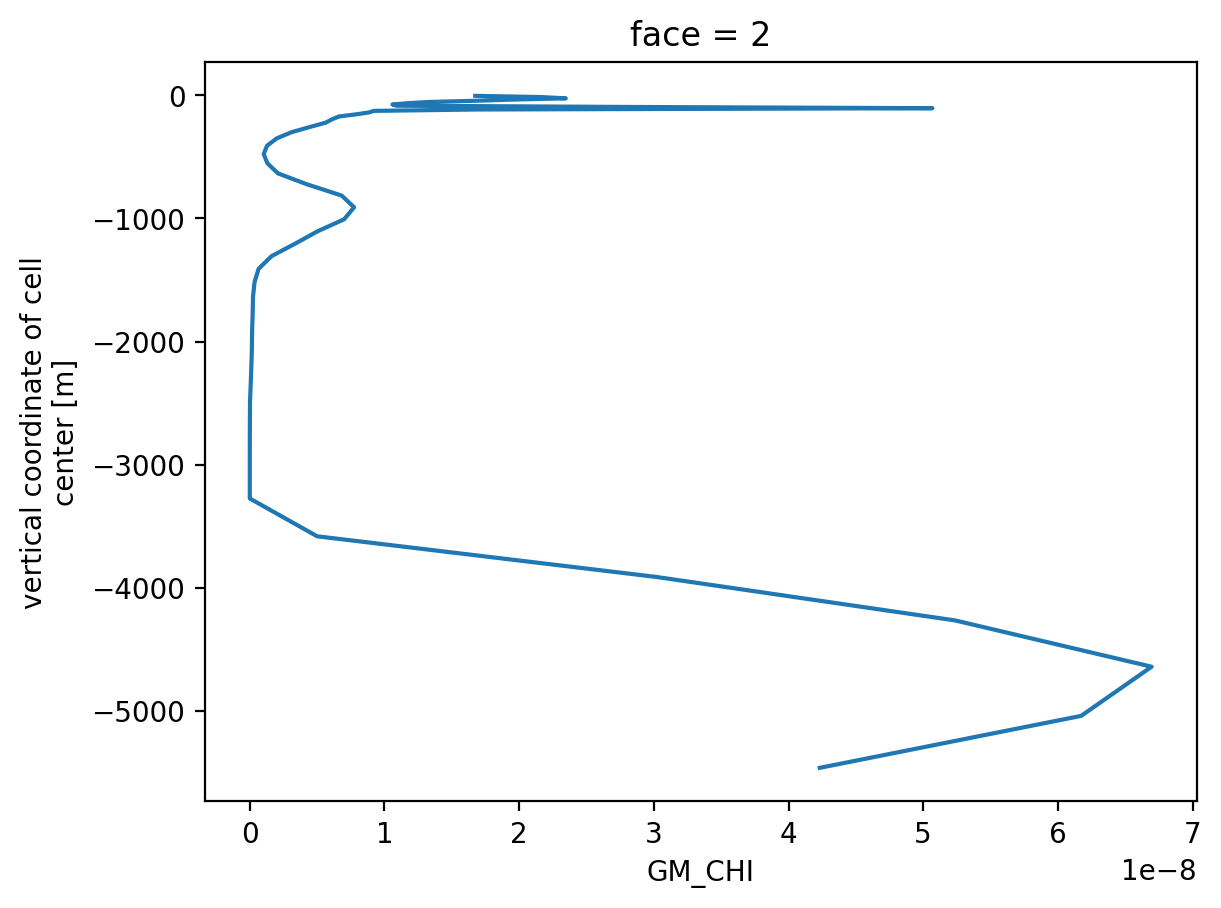

In [122]:
natre.GM_CHI.mean(["time", "j", "i"]).plot(y="Z")

## Development

### Checking CHIX, CHIXO, CHIY, CHIYO

In [253]:
ds["chix_"] = ds.GM_Kux * ds.Tx**2
ds["chixo_"] = 2 * ds.GM_Kuz * ds.Tx * grid.interp(ds.Tz, axis=["X", "Z"])
ds["chiy_"] = ds.GM_Kvy * ds.Ty**2
ds["chiyo_"] = 2 * ds.GM_Kvz * ds.Ty * grid.interp(ds.Tz, axis=["Y", "Z"])

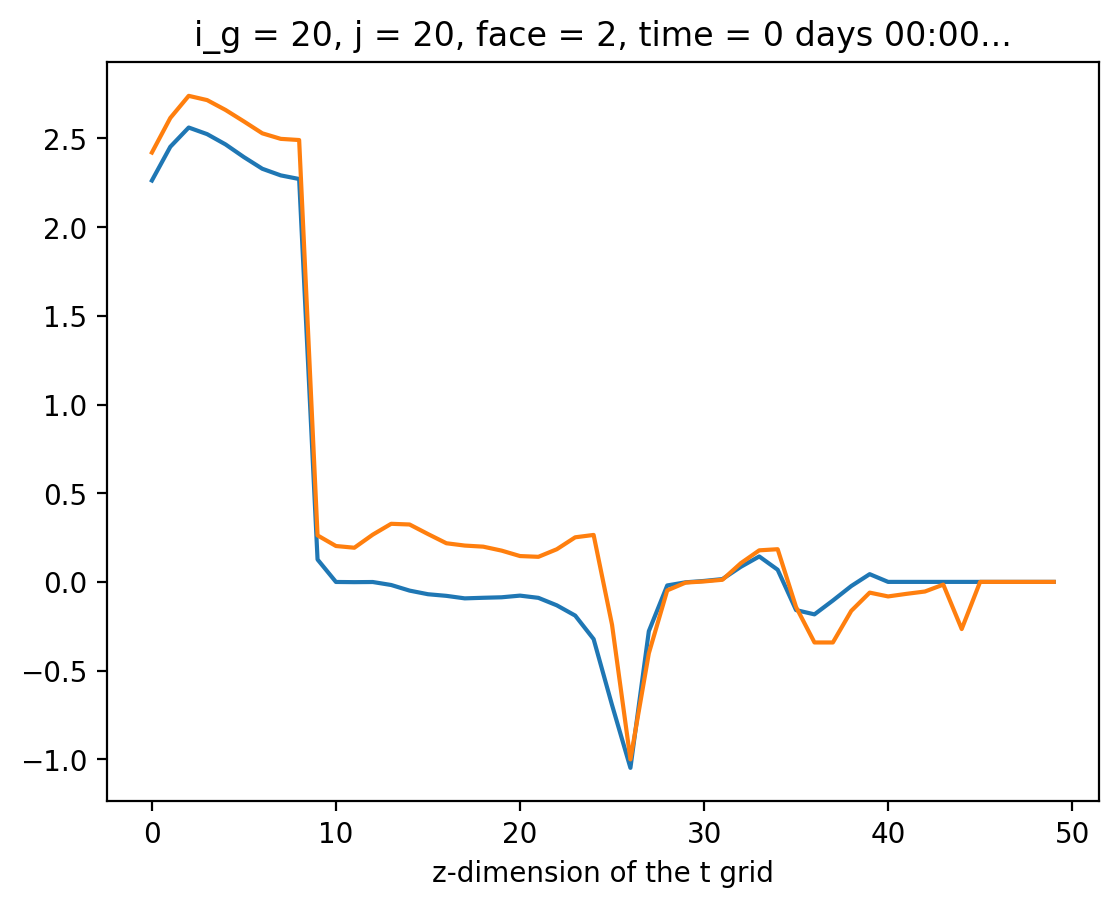

In [254]:
ds[["GM_Kvz"]].isel(time=5, j_g=20, i=20).to_array().plot(hue="variable")
ds[["GM_Kuz"]].isel(time=5, j=20, i_g=20).to_array().plot(hue="variable")

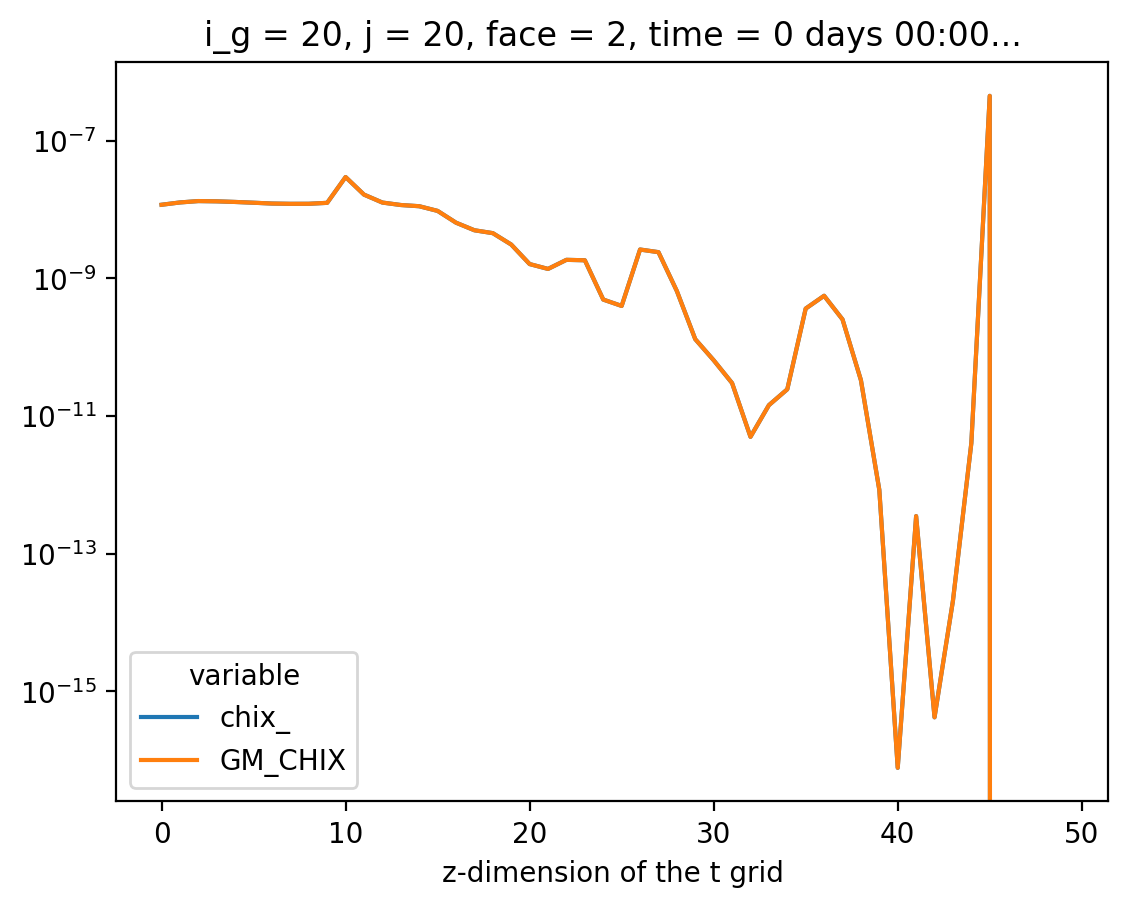

In [255]:
ds[["chix_", "GM_CHIX"]].isel(time=5, j=20, i_g=20).to_array().plot(
    hue="variable", yscale="log"
)

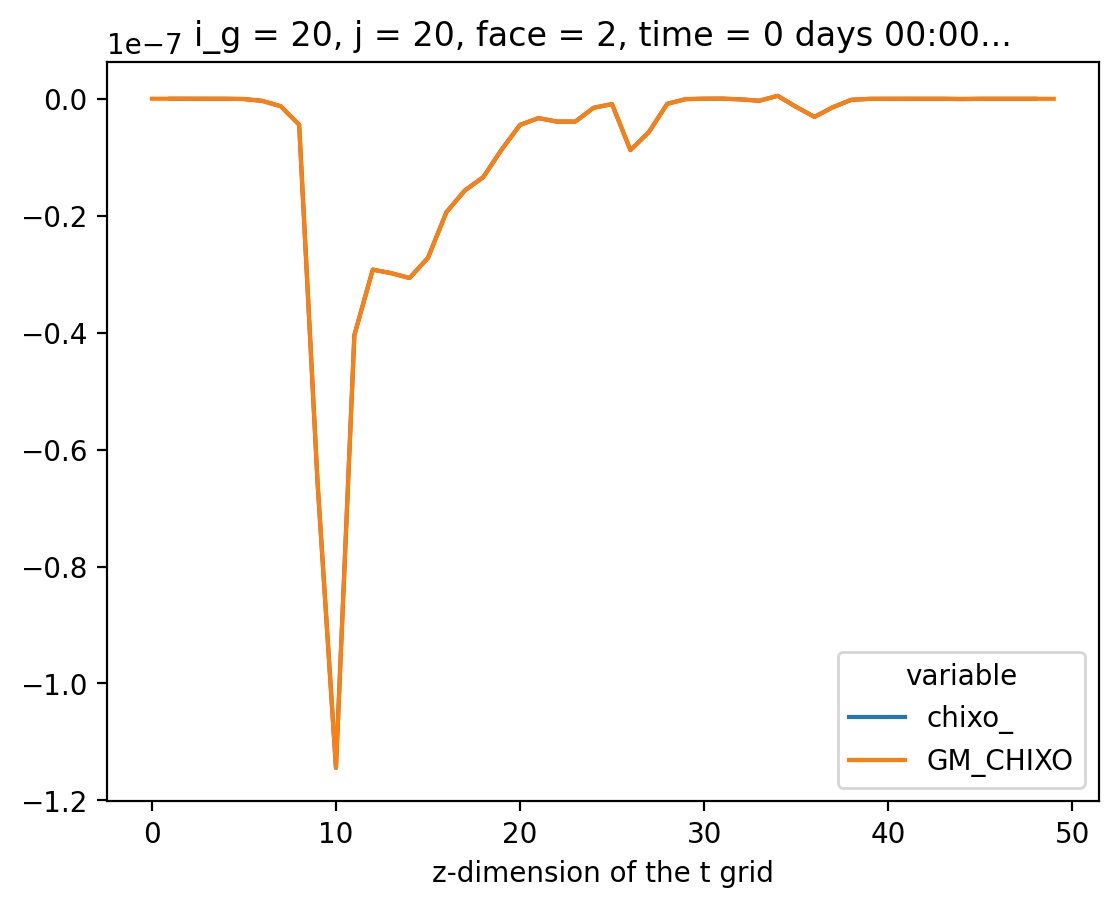

In [256]:
ds[["chixo_", "GM_CHIXO"]].isel(time=5, j=20, i_g=20).to_array().plot(hue="variable")

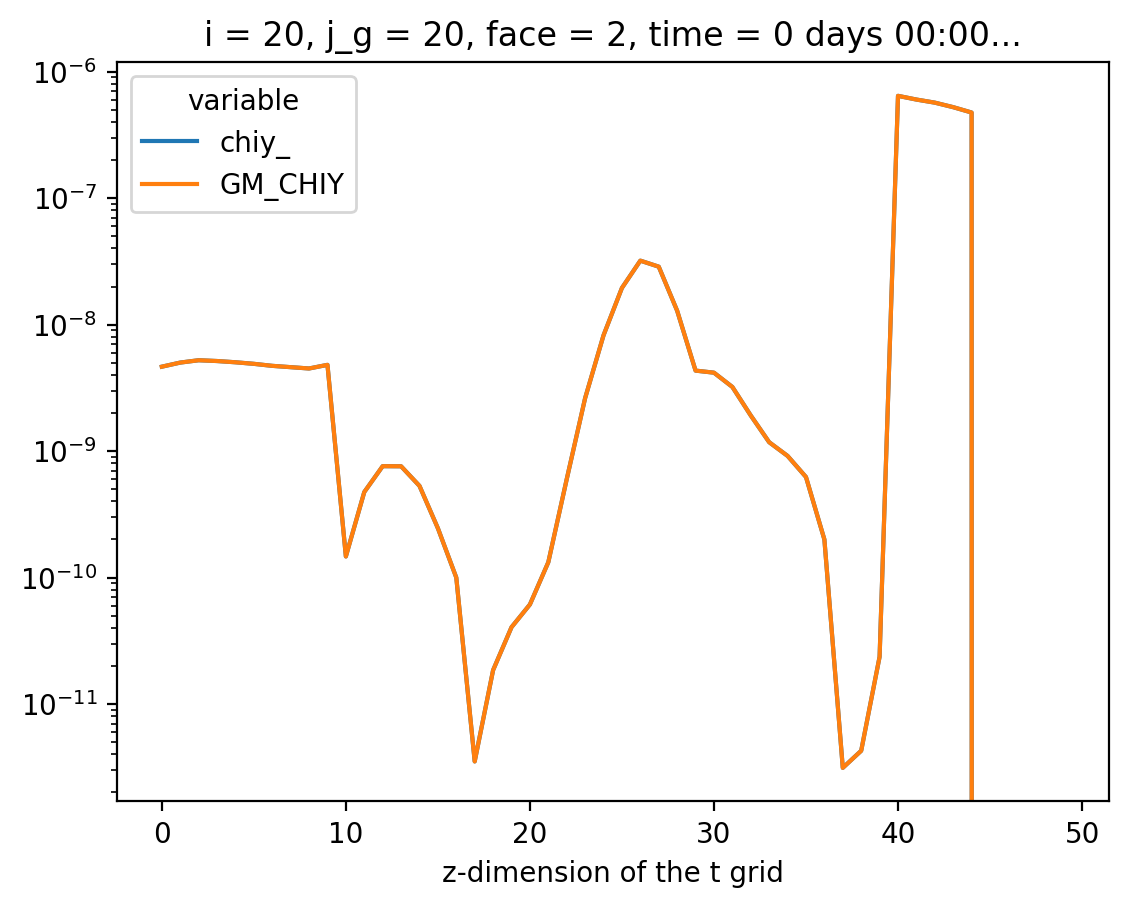

In [257]:
ds[["chiy_", "GM_CHIY"]].isel(time=5, j_g=20, i=20).to_array().plot(
    hue="variable", yscale="log"
)

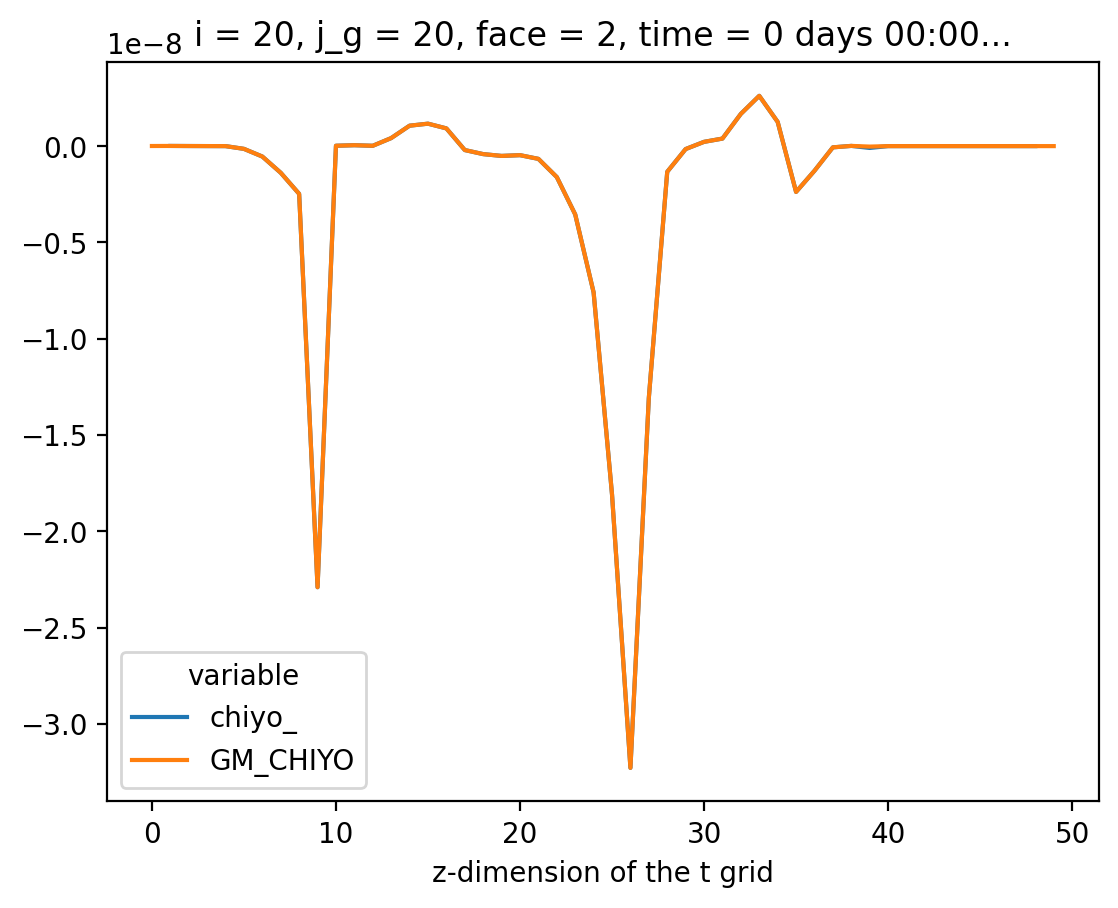

In [260]:
ds[["chiyo_", "GM_CHIYO"]].isel(time=5, j_g=20, i=20).to_array().plot(
    hue="variable",
)

### Checking CHIZ

In [290]:
subset = ds.isel(time=4, i_g=4, i=4, j=39, j_g=39)
subset["GM_Tz"] = subset["GM_KwzTz"] / subset.GM_Kwz / subset.rA
# subset["THETA"] = ds.THETA.isel(time=5,i=4, j=39)
subset = subset.load()

`subset.drC.isel(k_p1=slice(1, None))` still seems right

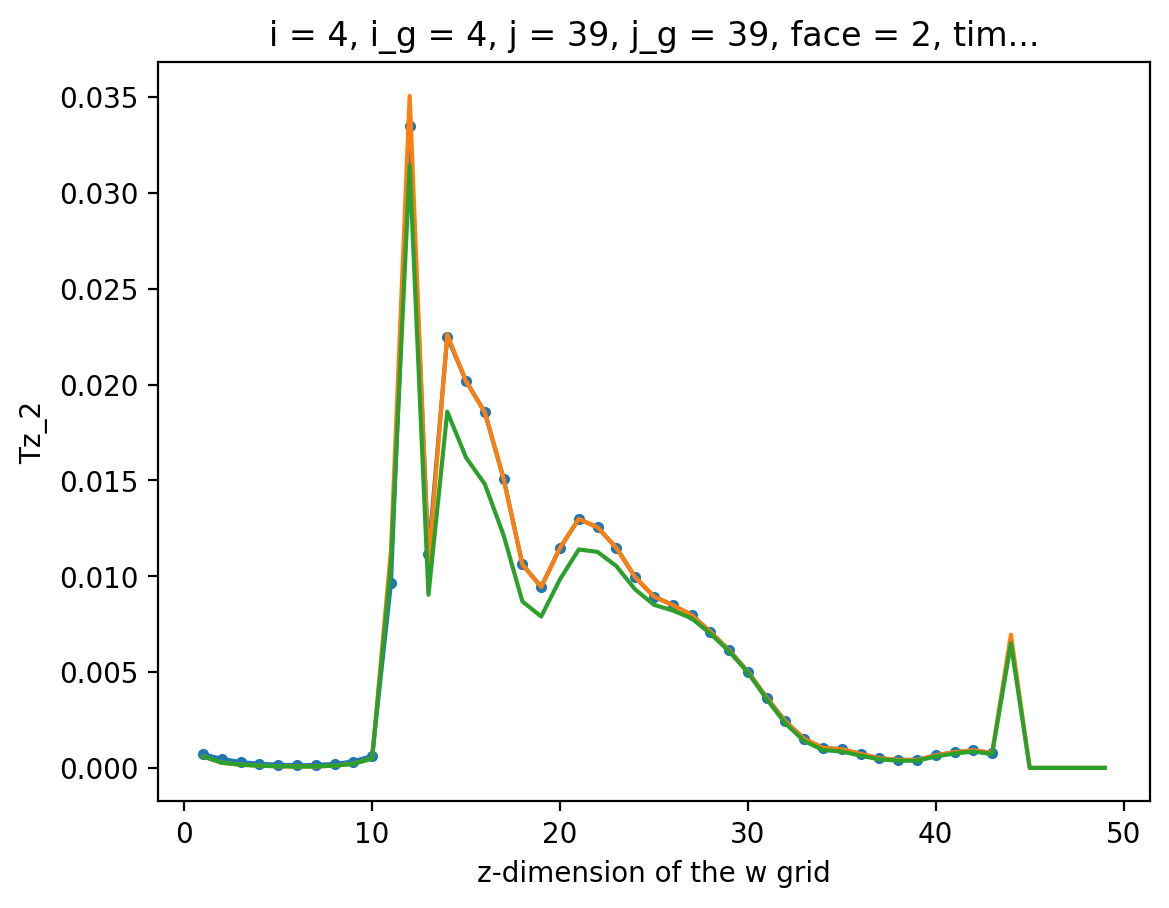

In [291]:
subset["Tz_2"] = (
    -grid.diff(subset.THETA, "Z")
    / subset.drC.isel(k_p1=slice(1, None)).rename({"k_p1": "k_l"}).variable
)

# (subset["GM_KwzTz"] * subset["GM_KwzTz"] / subset.GM_Kwz / subset.rA**2).plot()
np.sqrt(subset.GM_CHIZ / subset.GM_Kwz).plot(marker=".")
np.abs(subset.Tz).plot()
np.abs(subset.Tz_2).plot()

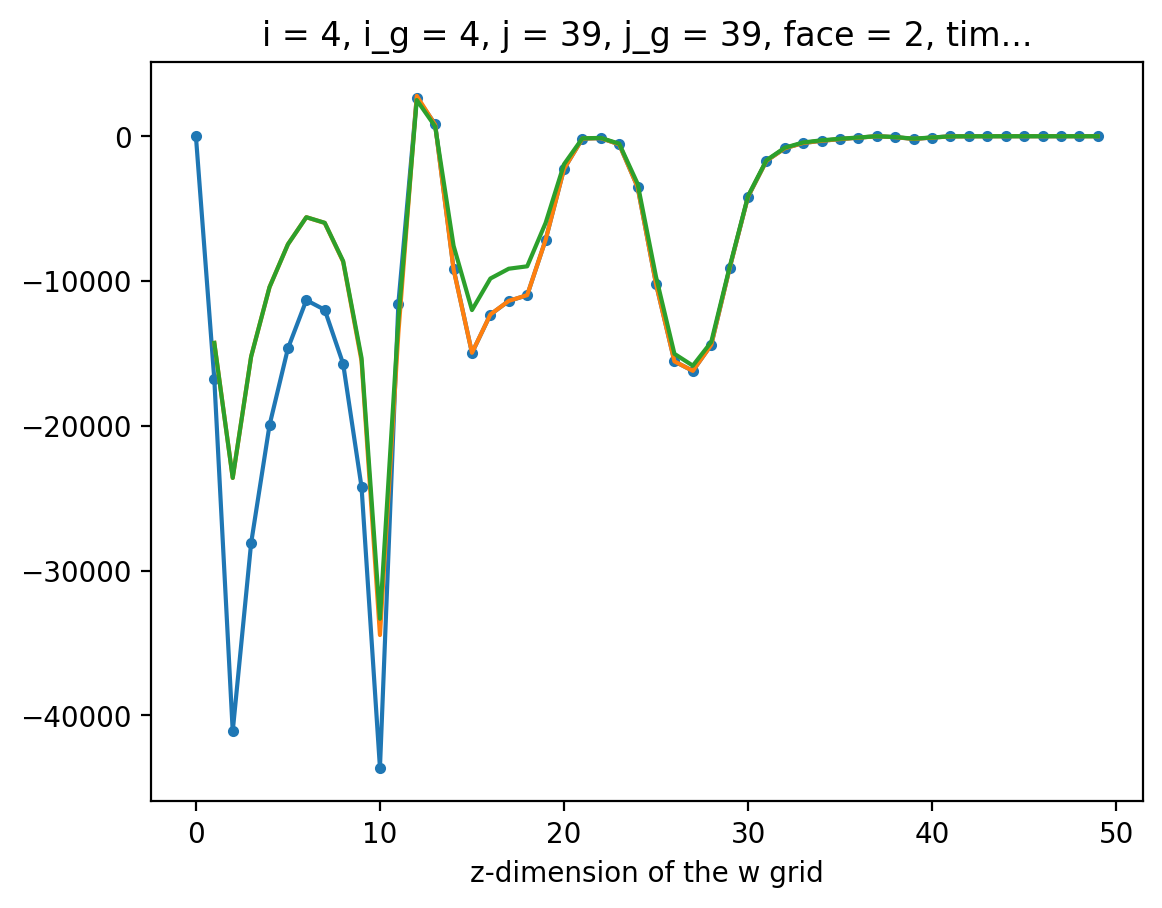

In [292]:
(subset["GM_KwzTz"]).plot(marker=".")
(-subset.GM_Kwz * subset.Tz * subset.rA).plot()
(-subset.GM_Kwz * subset.Tz_2 * subset.rA).plot()

### Is `Kvz` == `Kwy`?

Seems close, and errors from averaging probably?

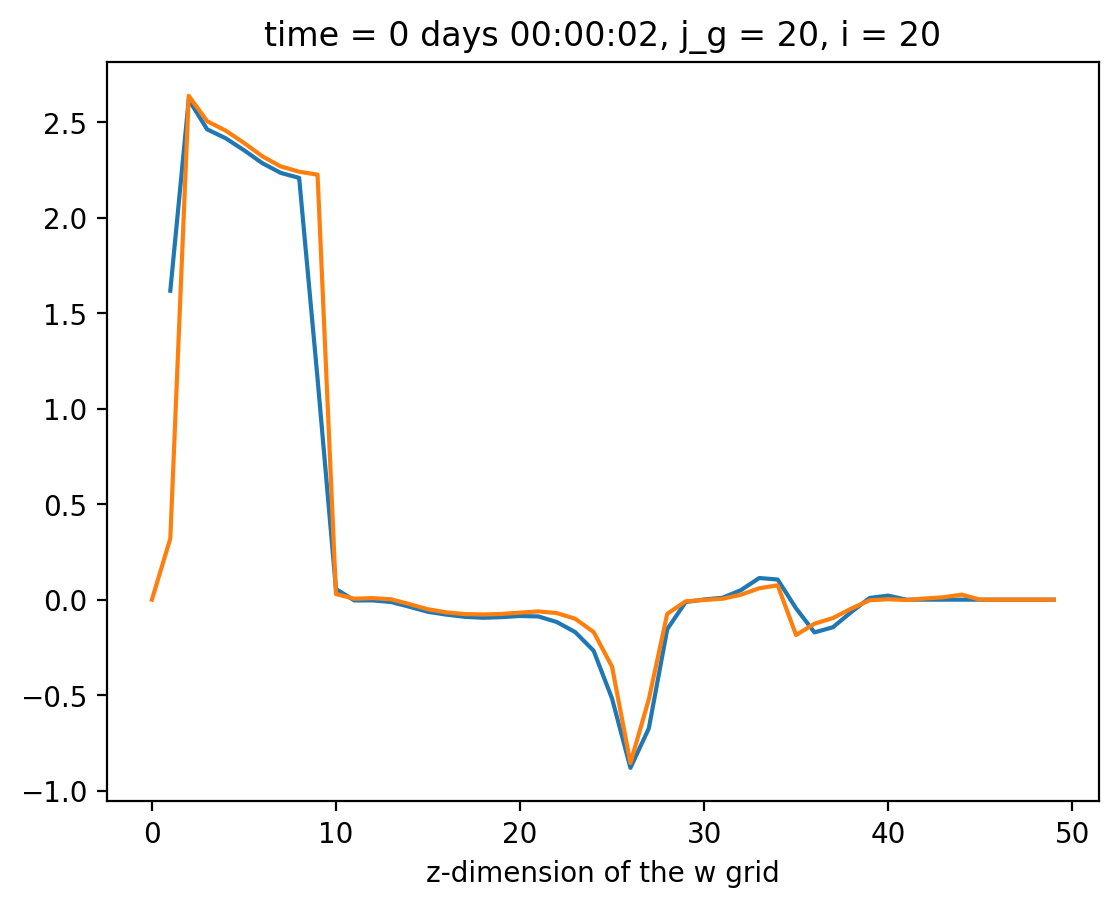

In [52]:
grid.interp(ds.GM_Kvz, axis="Z").isel(j_g=20, i=20, time=1).plot()
grid.interp(ds.GM_Kwy, axis="Y").isel(j_g=20, i=20, time=1).plot()

### File reading experiments

In [ ]:
ecco.read_llc_to_tiles(
    dirname + "GM_CHIZ_INST/", "GM_CHIZ.0000000001.data", nk=50, nl=1, use_xmitgcm=True
)

read_llc_to_tiles: full_filename:  /glade/work/dcherian/mitgcm/ECCOV4/release4/run/diags/GM_CHIZ_INST//GM_CHIZ.0000000001.data


dask.array<llc, shape=(1, 50, 13, 90, 90), dtype=>f4, chunksize=(1, 1, 1, 90, 90), chunktype=numpy.ndarray>

In [ ]:
import xmitgcm

In [ ]:
xmitgcm.open_mdsdataset(dirname + "GM_CHIZ_INST/", dirname + "../")

<xarray.Dataset>
Dimensions:    (XC: 90, YC: 1170, XG: 90, YG: 1170, Z: 50, Zp1: 51, Zu: 50,
                Zl: 50, time: 8)
Coordinates: (12/33)
  * XC         (XC) >f4 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
  * YC         (YC) >f4 0.0 0.0 0.0 0.0 0.0 ... 9.482 -57.27 67.47 9.482 -57.27
  * XG         (XG) >f4 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
  * YG         (YG) >f4 0.0 0.0 0.0 0.0 0.0 ... 9.97 -57.01 67.56 9.97 -57.01
  * Z          (Z) >f4 -5.0 -15.0 -25.0 ... -5.039e+03 -5.461e+03 -5.906e+03
  * Zp1        (Zp1) >f4 0.0 -10.0 -20.0 ... -5.244e+03 -5.678e+03 -6.134e+03
    ...         ...
    maskCtrlC  (Z, YC, XC) bool dask.array<chunksize=(50, 1170, 90), meta=np.ndarray>
    maskCtrlS  (Z, YG, XC) bool dask.array<chunksize=(50, 1170, 90), meta=np.ndarray>
    rhoRef     (Z) >f4 dask.array<chunksize=(50,), meta=np.ndarray>
    maskCtrlW  (Z, YC, XG) bool dask.array<chunksize=(50, 1170, 90), meta=np.ndarray>
    iter       (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time       (time) timedelta64[ns] 00:00:01 00:00:02 ... 00:00:07 00:00:08
Data variables:
    GM_CHIZ    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 50, 1170, 90), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir='/glade/work/d...

In [ ]:
chiz = ecco.llc_tiles_to_xda(
    ecco.read_llc_to_tiles(
        dirname + "GM_CHIZ_INST/",
        "GM_CHIZ.0000000001.data",
        nk=50,
        nl=1,
        use_xmitgcm=True,
    ),
    var_type="c",
    dim4="depth",
    dim5="time",
)
chiz

read_llc_to_tiles: full_filename:  /glade/work/dcherian/mitgcm/ECCOV4/release4/run/diags/GM_CHIZ_INST//GM_CHIZ.0000000001.data


<xarray.DataArray 'llc-2d8997a5c3544544991ec6632d79eee9' (time: 1, k: 50,
                                                          tile: 13, j: 90, i: 90)>
dask.array<llc, shape=(1, 50, 13, 90, 90), dtype=>f4, chunksize=(1, 1, 1, 90, 90), chunktype=numpy.ndarray>
Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * time     (time) int64 0
  * tile     (tile) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89

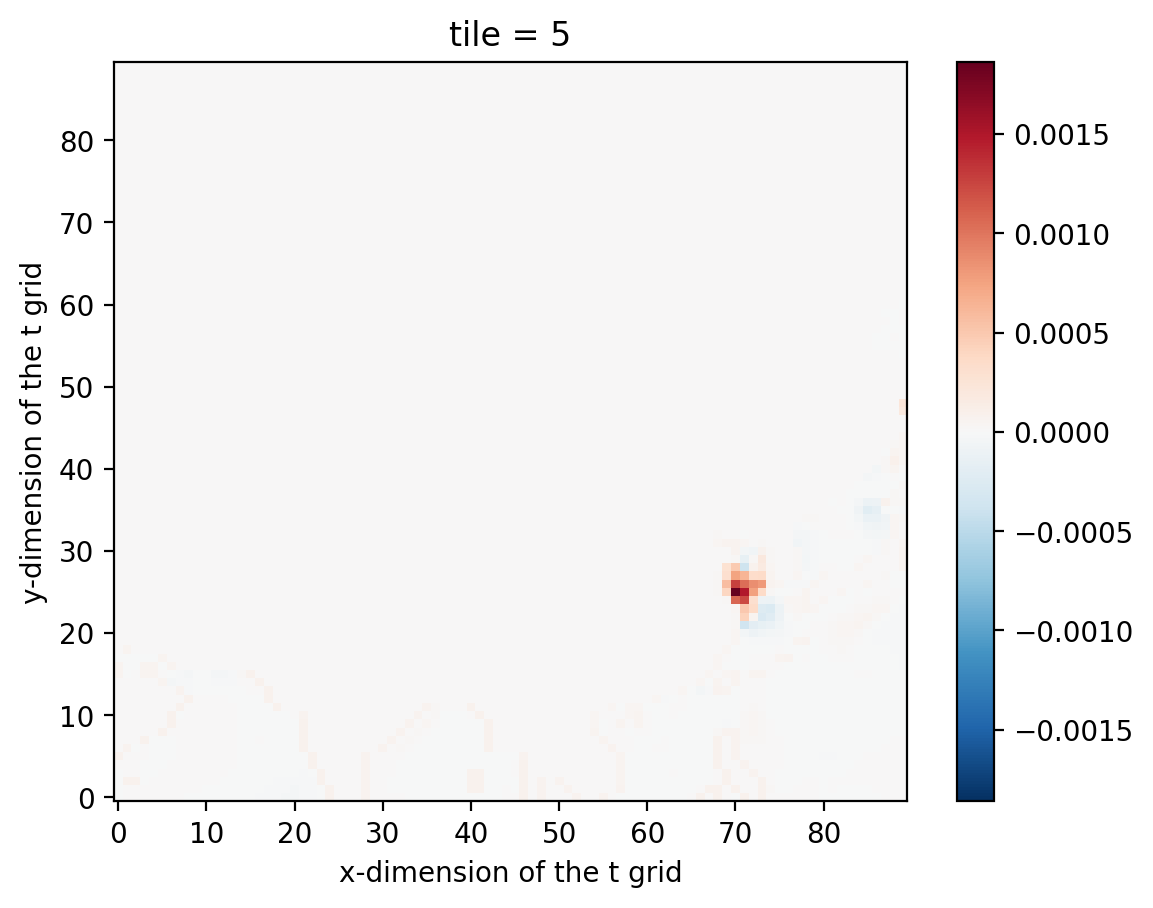

In [10]:
chix.sel(tile=5).plot()

## Tracking down gradient calculation in `gmredi_ytransport.F`

Here, I saved the `dTdz` in `gmredi_ytransport.F` as `GM_CHIYO`

`dTdz_v` replicates the calculation.

This helped tracked down a bug in `ds.drC_kl` (we want `drC.isel(kp1=slice(-1))` instead of `drC.isel(kp1=slice(1, None))`

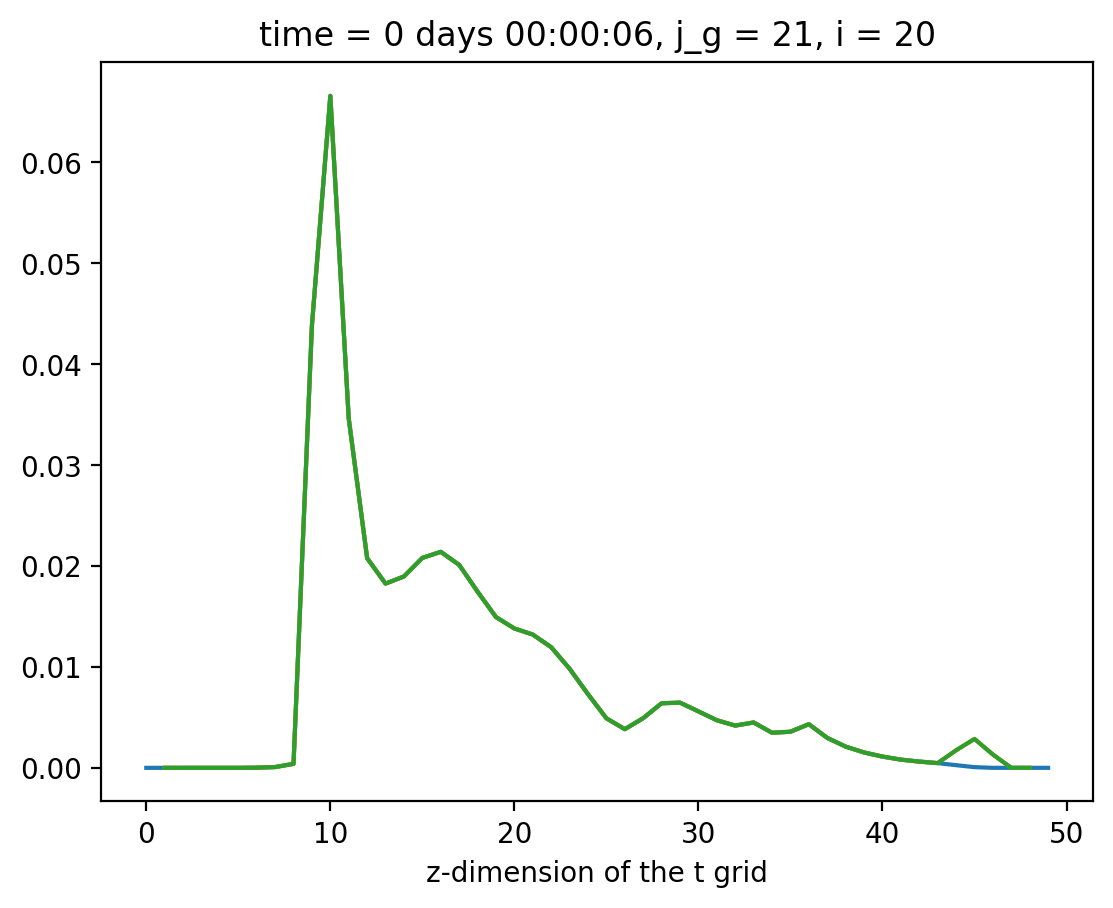

In [185]:
ΔT_z = -1 * grid.diff(ds.THETA, "Z")
ΔT_z_y = grid.interp(ΔT_z, "Y")
dTdz_v = grid.interp(ΔT_z_y / ds.drC_kl, "Z")

(ds.GM_CHIYO).isel(time=5, j_g=21, i=20).plot()
(dTdz_v).isel(time=5, j_g=21, i=20).plot()
(grid.interp(ds.Tz, axis=["Z", "Y"])).isel(time=5, j_g=21, i=20).plot()